#classical_models

In [1]:
#!git clone https://github.com/leonardoLavagna/qaoa

In [2]:
import pickle
import sys
import os
os.chdir("qaoa")

In [3]:
#!pip install -r requirements.txt
#!pip install torch_geometric

In [4]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
from torch_geometric.utils import from_networkx
from sklearn.metrics import mean_squared_error, mean_absolute_error
from config import *

In [5]:
class MaxCutMLP(nn.Module):
    def __init__(self, input_size, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)


class MaxCutGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=2, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * 2, hidden_dim, heads=1, concat=False, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.gat1(data.x, data.edge_index))
        x = F.relu(self.gat2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.sage1(data.x, data.edge_index))
        x = F.relu(self.sage2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)


class MaxCutGIN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        mlp1 = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        mlp2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(mlp1)
        self.conv2 = GINConv(mlp2)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)

In [6]:
def train_vec(model, X_train, y_train, X_test, y_test, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train).squeeze()
        loss = loss_fn(out, y_train.squeeze())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"[MLP] Epoch {epoch+1}, Loss: {loss.item():.4f}")
    model.eval()
    with torch.no_grad():
        preds = model(X_test).squeeze()
    #plt.figure(figsize=(6, 4))
    #plt.plot(losses, label="Training Loss")
    #plt.xlabel("Epoch")
    #plt.ylabel("Loss")
    #plt.title("MLP Training Loss")
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()
    return preds.tolist(), y_test.squeeze().tolist(), losses


def train_gnn(model, train_data, test_data, epochs=100, batch_size=32):
    loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch).squeeze()
            loss = loss_fn(out, batch.y.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"[{model.__class__.__name__}] Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    #plt.figure(figsize=(6, 4))
    #plt.plot(losses, label="Training Loss")
    #plt.xlabel("Epoch")
    #plt.ylabel("Loss")
    #plt.title(f"{model.__class__.__name__} Training Loss")
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for g in test_data:
            pred = model(g).item()
            preds.append(pred)
            targets.append(g.y.item())
    return preds, targets, losses

In [7]:
def evaluate_and_plot(preds, targets, name="Model"):
    preds, targets = np.array(preds), np.array(targets)
    ratios = preds / np.maximum(targets, 1e-6)
    mse = np.mean((preds - targets) ** 2)
    print(f"\n--- {name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"Mean Approx. Ratio: {ratios.mean():.4f}")
    plt.figure(figsize=(6, 4))
    plt.scatter(targets, preds, alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.xlabel("True MaxCut")
    plt.ylabel("Predicted")
    plt.title(f"{name}: Prediction vs True")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6, 4))
    plt.hist(ratios, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(ratios.mean(), color='red', linestyle='--', label=f"Mean = {ratios.mean():.2f}")
    plt.xlabel("Approximation Ratio")
    plt.ylabel("Frequency")
    plt.title(f"{name}: Approximation Ratios")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
def exact_maxcut(adj):
    n = adj.shape[0]
    max_cut = 0
    for partition in range(1, 1 << (n - 1)):
        A = [i for i in range(n) if partition & (1 << i)]
        B = [i for i in range(n) if not (partition & (1 << i))]
        cut_value = sum(abs(adj[i, j]) for i in A for j in B)
        max_cut = max(max_cut, cut_value)
    return max_cut


def graph_to_vector(adj, cut):
    edge_weights = adj[np.triu_indices(adj.shape[0], k=1)]
    return torch.tensor(edge_weights, dtype=torch.float32), torch.tensor([cut], dtype=torch.float32)


def graph_to_pyg(adj, cut, max_nodes=6):
    n = adj.shape[0]
    edge_index = torch.combinations(torch.arange(n), r=2).t()
    edge_weights = adj[np.triu_indices(n, k=1)]
    x = F.pad(torch.eye(n), (0, max_nodes - n), value=0)
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=torch.tensor(edge_weights, dtype=torch.float32).unsqueeze(1),
        y=torch.tensor([cut], dtype=torch.float32)
    )


def pad_vectors(data_vec, max_len=None):
    if max_len is None:
        max_len = max(x.shape[0] for x, _ in data_vec)

    padded_x, y_values = [], []
    for x, y in data_vec:
        x_padded = F.pad(x, (0, max_len - x.shape[0]), value=0)
        padded_x.append(x_padded)
        y_values.append(y)

    return torch.stack(padded_x), torch.stack(y_values), max_len


def load_graphs_from_nx(data_dir="data/", max_nodes=100):
    data_pyg, data_vec = [], []
    for fname in os.listdir(data_dir):
        if not fname.endswith(".nx"):
            continue
        with open(os.path.join(data_dir, fname), "rb") as f:
            graph_wrapper = pickle.load(f)
            G = graph_wrapper.get_graph()
        A = nx.to_numpy_array(G)
        cut = exact_maxcut(A)
        data_vec.append(graph_to_vector(A, cut))
        data_pyg.append(graph_to_pyg(A, cut, max_nodes=max_nodes))

    return train_test_split(data_pyg, test_size=0.2), train_test_split(data_vec, test_size=0.2)

In [9]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [10]:
runs = 10
model_names = ["MLP", "GCN", "GAT", "GraphSAGE", "GIN"]

In [11]:
all_losses = {name: [] for name in model_names}
all_preds = {name: [] for name in model_names}
all_trues = []

In [12]:
for run in range(runs):
    print(f"\n--- Seeded Run {run+1} ---")
    set_seed(run)
    (pyg_train, pyg_test), (vec_train, vec_test) = load_graphs_from_nx(data_dir="data/")
    X_train, y_train, max_len = pad_vectors(vec_train)
    X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
    mlp = MaxCutMLP(input_size=X_train.shape[1])
    preds, true, losses = train_vec(mlp, X_train, y_train, X_test, y_test)
    all_losses["MLP"].append(losses)
    all_preds["MLP"].append(preds)
    if run == 0:
        all_trues = true
    for Model, name in [(MaxCutGCN, "GCN"),(MaxCutGAT, "GAT"),(MaxCutGraphSAGE, "GraphSAGE"),(MaxCutGIN, "GIN")]:
        model = Model(input_dim=pyg_train[0].x.shape[1], hidden_dim=32)
        preds, _, losses = train_gnn(model, pyg_train, pyg_test)
        all_losses[name].append(losses)
        all_preds[name].append(preds)

Output streaming troncato alle ultime 5000 righe.
[MLP] Epoch 19, Loss: 6.9200
[MLP] Epoch 20, Loss: 4.8242
[MLP] Epoch 21, Loss: 2.7124
[MLP] Epoch 22, Loss: 1.3311
[MLP] Epoch 23, Loss: 1.1707
[MLP] Epoch 24, Loss: 2.1045
[MLP] Epoch 25, Loss: 3.3119
[MLP] Epoch 26, Loss: 3.8104
[MLP] Epoch 27, Loss: 3.2269
[MLP] Epoch 28, Loss: 1.9886
[MLP] Epoch 29, Loss: 0.8634
[MLP] Epoch 30, Loss: 0.3465
[MLP] Epoch 31, Loss: 0.4641
[MLP] Epoch 32, Loss: 0.9221
[MLP] Epoch 33, Loss: 1.3624
[MLP] Epoch 34, Loss: 1.5383
[MLP] Epoch 35, Loss: 1.3800
[MLP] Epoch 36, Loss: 0.9853
[MLP] Epoch 37, Loss: 0.5534
[MLP] Epoch 38, Loss: 0.2899
[MLP] Epoch 39, Loss: 0.3104
[MLP] Epoch 40, Loss: 0.5323
[MLP] Epoch 41, Loss: 0.7264
[MLP] Epoch 42, Loss: 0.7155
[MLP] Epoch 43, Loss: 0.5268
[MLP] Epoch 44, Loss: 0.2820
[MLP] Epoch 45, Loss: 0.1071
[MLP] Epoch 46, Loss: 0.0683
[MLP] Epoch 47, Loss: 0.1379
[MLP] Epoch 48, Loss: 0.2352
[MLP] Epoch 49, Loss: 0.2864
[MLP] Epoch 50, Loss: 0.2634
[MLP] Epoch 51, Loss: 

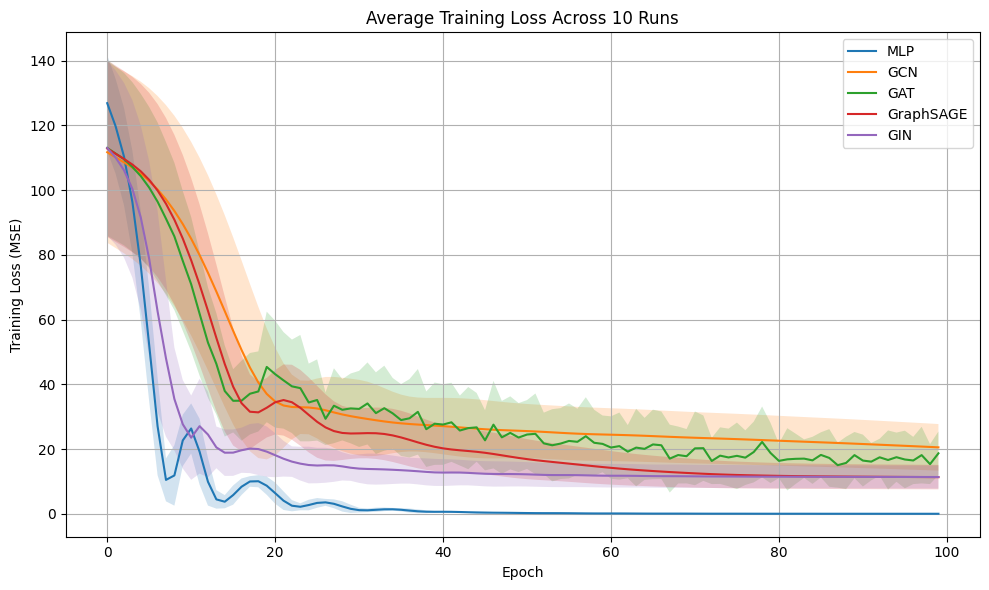

In [13]:
plt.figure(figsize=(10, 6))
for name, runs_losses in all_losses.items():
    losses_matrix = np.array([np.array(l) for l in runs_losses])
    mean_loss = losses_matrix.mean(axis=0)
    std_loss = losses_matrix.std(axis=0)

    epochs = np.arange(len(mean_loss))
    plt.plot(epochs, mean_loss, label=name)
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Average Training Loss Across 10 Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_qaoa_dataset.png", dpi=300)
plt.show()

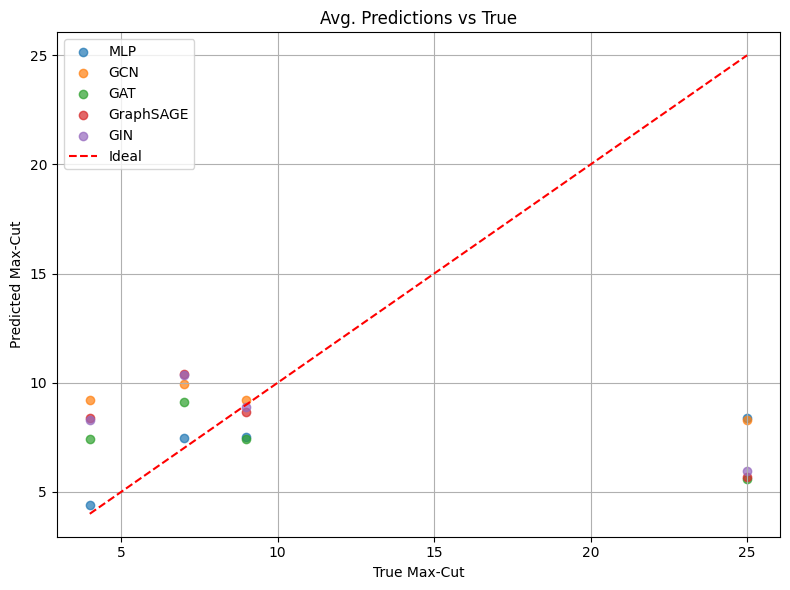

In [14]:
plt.figure(figsize=(8, 6))
true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    plt.scatter(true_vals, mean_preds, label=name, alpha=0.7)

lims = [min(true_vals.min(), mean_preds.min()), max(true_vals.max(), mean_preds.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("True Max-Cut")
plt.ylabel("Predicted Max-Cut")
plt.title("Avg. Predictions vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pred_vs_true_qaoa_dataset.png", dpi=300)
plt.show()


In [15]:
results_lines = []
results_lines.append("--- Aggregated Test Evaluation over All Runs ---\n")

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    true_vals = np.array(all_trues)
    mean_preds = preds_matrix.mean(axis=0)
    std_preds = preds_matrix.std(axis=0)
    # Metrics
    mse = mean_squared_error(true_vals, mean_preds)
    mae = mean_absolute_error(true_vals, mean_preds)
    approx_ratios = mean_preds / np.maximum(true_vals, 1e-6)
    mean_ratio = approx_ratios.mean()
    std_ratio = approx_ratios.std()
    # Store results as string
    results_lines.append(f"{name} Results:")
    results_lines.append(f"  MSE:  {mse:.4f}")
    results_lines.append(f"  MAE:  {mae:.4f}")
    results_lines.append(f"  Approx Ratio:  {mean_ratio:.4f} ± {std_ratio:.4f}\n")

# Write to file
output_path = "results_qaoa_dataset.txt"
with open(output_path, "w") as f:
    f.write("\n".join(results_lines))

print(f"\n✅ Results saved to {output_path}")


✅ Results saved to results_qaoa_dataset.txt


## Random graphs only

In [16]:
def generate_erdos_renyi_dataset(n_samples=300, min_nodes=4, max_nodes=16, p=0.5, weight_range=5, test_ratio=0.2):
    data_pyg, data_vec = [], []
    for _ in range(n_samples):
        n = np.random.randint(min_nodes, max_nodes + 1)
        G = nx.erdos_renyi_graph(n, p)
        if len(G.edges) == 0:
            continue
        for u, v in G.edges():
            G[u][v]['weight'] = np.random.randint(-weight_range, weight_range + 1)
        A = nx.to_numpy_array(G, weight='weight')
        cut = exact_maxcut(A)
        data_vec.append(graph_to_vector(A, cut))
        data_pyg.append(graph_to_pyg(A, cut, max_nodes=max_nodes))
    return train_test_split(data_pyg, test_size=test_ratio), train_test_split(data_vec, test_size=test_ratio)

In [17]:
all_losses = {name: [] for name in model_names}
all_preds = {name: [] for name in model_names}
all_trues_per_run = {name: [] for name in model_names}

for run in range(runs):
    print(f"\n--- Seeded Run {run+1} ---")
    set_seed(run)
    (pyg_train, pyg_test), (vec_train, vec_test) = generate_erdos_renyi_dataset()
    X_train, y_train, max_len = pad_vectors(vec_train)
    X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
    mlp = MaxCutMLP(input_size=X_train.shape[1])
    preds, true, losses = train_vec(mlp, X_train, y_train, X_test, y_test)
    all_losses["MLP"].append(losses)
    all_preds["MLP"].append(preds)
    if run == 0:
        all_trues = true
    for Model, name in [(MaxCutGCN, "GCN"),(MaxCutGAT, "GAT"),(MaxCutGraphSAGE, "GraphSAGE"),(MaxCutGIN, "GIN")]:
        model = Model(input_dim=pyg_train[0].x.shape[1], hidden_dim=32)
        preds, _, losses = train_gnn(model, pyg_train, pyg_test)
        all_losses[name].append(losses)
        all_preds[name].append(preds)

Output streaming troncato alle ultime 5000 righe.
[MLP] Epoch 19, Loss: 103.0541
[MLP] Epoch 20, Loss: 67.7213
[MLP] Epoch 21, Loss: 98.1271
[MLP] Epoch 22, Loss: 157.4389
[MLP] Epoch 23, Loss: 215.2363
[MLP] Epoch 24, Loss: 252.5473
[MLP] Epoch 25, Loss: 261.2012
[MLP] Epoch 26, Loss: 241.7884
[MLP] Epoch 27, Loss: 200.8714
[MLP] Epoch 28, Loss: 148.8838
[MLP] Epoch 29, Loss: 98.2665
[MLP] Epoch 30, Loss: 60.7159
[MLP] Epoch 31, Loss: 43.8745
[MLP] Epoch 32, Loss: 47.9321
[MLP] Epoch 33, Loss: 64.8251
[MLP] Epoch 34, Loss: 81.4260
[MLP] Epoch 35, Loss: 86.3397
[MLP] Epoch 36, Loss: 75.7849
[MLP] Epoch 37, Loss: 54.6338
[MLP] Epoch 38, Loss: 32.2245
[MLP] Epoch 39, Loss: 16.6983
[MLP] Epoch 40, Loss: 11.6192
[MLP] Epoch 41, Loss: 15.5996
[MLP] Epoch 42, Loss: 24.1722
[MLP] Epoch 43, Loss: 32.3284
[MLP] Epoch 44, Loss: 36.3903
[MLP] Epoch 45, Loss: 34.9407
[MLP] Epoch 46, Loss: 28.8345
[MLP] Epoch 47, Loss: 20.5184
[MLP] Epoch 48, Loss: 12.9679
[MLP] Epoch 49, Loss: 8.5215
[MLP] Epoch 5

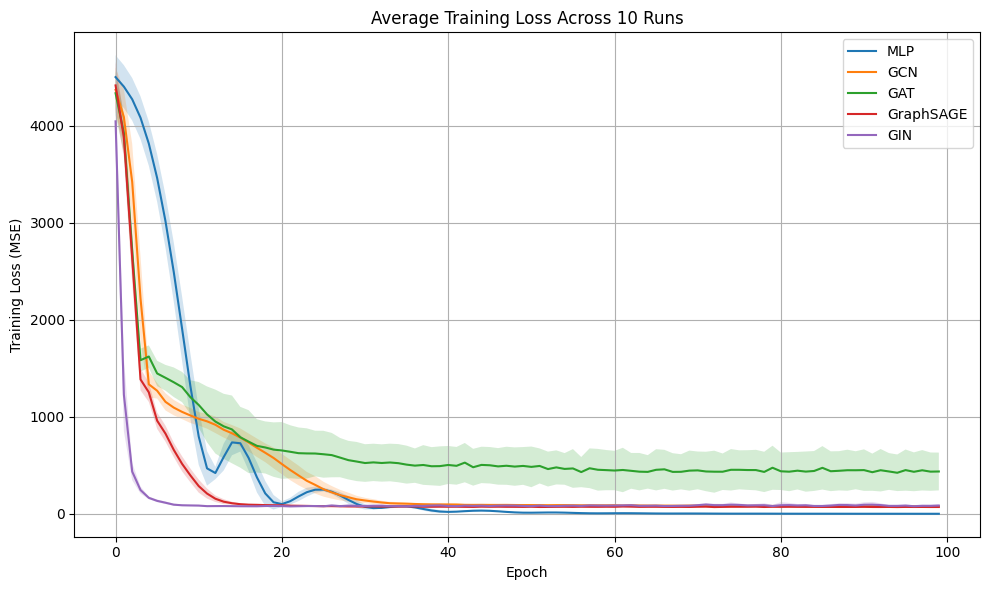

In [18]:
plt.figure(figsize=(10, 6))
for name, runs_losses in all_losses.items():
    losses_matrix = np.array([np.array(l) for l in runs_losses])
    mean_loss = losses_matrix.mean(axis=0)
    std_loss = losses_matrix.std(axis=0)

    epochs = np.arange(len(mean_loss))
    plt.plot(epochs, mean_loss, label=name)
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Average Training Loss Across 10 Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_er_dataset.png", dpi=300)
plt.show()

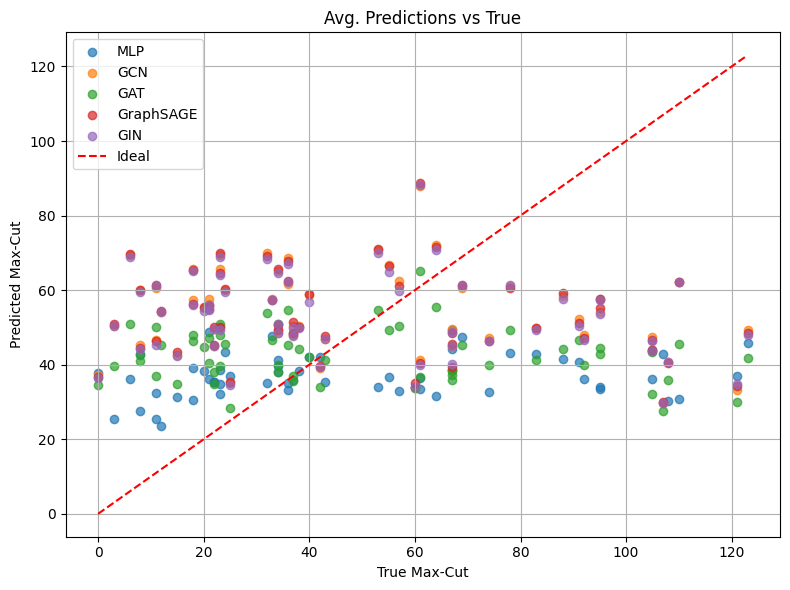

In [19]:
plt.figure(figsize=(8, 6))
true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    plt.scatter(true_vals, mean_preds, label=name, alpha=0.7)

lims = [min(true_vals.min(), mean_preds.min()), max(true_vals.max(), mean_preds.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("True Max-Cut")
plt.ylabel("Predicted Max-Cut")
plt.title("Avg. Predictions vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pred_vs_true_er_dataset.png", dpi=300)
plt.show()


In [20]:
results_lines = []
results_lines.append("--- Aggregated Test Evaluation over All Runs ---\n")

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    true_vals = np.array(all_trues)
    mean_preds = preds_matrix.mean(axis=0)
    std_preds = preds_matrix.std(axis=0)
    # Metrics
    mse = mean_squared_error(true_vals, mean_preds)
    mae = mean_absolute_error(true_vals, mean_preds)
    approx_ratios = mean_preds / np.maximum(true_vals, 1e-6)
    mean_ratio = approx_ratios.mean()
    std_ratio = approx_ratios.std()
    # Store results as string
    results_lines.append(f"{name} Results:")
    results_lines.append(f"  MSE:  {mse:.4f}")
    results_lines.append(f"  MAE:  {mae:.4f}")
    results_lines.append(f"  Approx Ratio:  {mean_ratio:.4f} ± {std_ratio:.4f}\n")

# Write to file
output_path = "results_er_dataset.txt"
with open(output_path, "w") as f:
    f.write("\n".join(results_lines))

print(f"\n✅ Results saved to {output_path}")


✅ Results saved to results_er_dataset.txt
